# Lecture 5.3: Linear Regression Using Gradient Descent

The codes and notes are by courtesy of [greyhatguy007](https://github.com/greyhatguy007/Machine-Learning-Specialization-Coursera ) and [Andrew NG](https://www.coursera.org/specializations/machine-learning-introduction).

In this lecture, we will implement linear regression with one input feature to predict profits for a restaurant franchise.



<a name="1"></a>
## 1. Packages 

First, let's run the cell below to import all the packages that we will need during this lecture.
- [numpy](www.numpy.org) is the fundamental package for working with matrices in Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- ``utils.py`` contains helper functions for this lecture.


In [1]:
import os
import sys
# module_path = os.path.abspath(os.path.join('..'))
# module_path = module_path + "/lectures/lecture5.3/"
# if module_path not in sys.path:
#     sys.path.append(module_path)
    
module_path = './'

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import timeit
import warnings
warnings.filterwarnings('ignore')
import copy
import math
%matplotlib inline

## 2.  Problem statement

Suppose we are the CEOs of a restaurant franchise and are considering different cities for opening a new outlet.
- We would like to expand our business to cities that may give our restaurant higher profits.
- The chain already has restaurants in various cities and we have data for profits and populations from the cities.
- We also have data on cities that are candidates for a new restaurant. 
    - For these cities, we have the city population.
    
We want to use the data identify which cities may potentially give our business higher profits.

## 3. Dataset

We will start by loading the dataset for this task. 
- The `load_data()` function shown below loads the data into variables `x_train` and `y_train`
  - `x_train` is the population of a city.
  - `y_train` is the profit of a restaurant in that city. A negative value for profit indicates a loss.   
  - Both `X_train` and `y_train` are numpy arrays.

In [2]:
# load the dataset
def load_data():
    data = np.loadtxt(module_path + "ex1data1.txt", delimiter=',')
    X = data[:,0]
    y = data[:,1]
    return X, y

def load_data_multi():
    data = np.loadtxt(module_path + "ex1data2.txt", delimiter=',')
    X = data[:,:2]
    y = data[:,2]
    return X, y

x_train, y_train = load_data()

#### View the variables
Before starting on any task, it is useful to get more familiar with the dataset.  
- A good place to start is to just print out each variable and see what it contains.

The code below prints the variable `x_train` and the type of the variable.

In [3]:
# print x_train
print("Type of x_train:",type(x_train))
print("First five elements of x_train are:\n", x_train[:5]) 

Type of x_train: <class 'numpy.ndarray'>
First five elements of x_train are:
 [6.1101 5.5277 8.5186 7.0032 5.8598]


`x_train` is a numpy array that contains decimal values that are all greater than zero.
- These values represent the city population times 10,000.
- For example, 6.1101 means that the population for that city is 61,101.
  
Now, let's print `y_train`.

In [4]:
# print y_train
print("Type of y_train:",type(y_train))
print("First five elements of y_train are:\n", y_train[:5])  

Type of y_train: <class 'numpy.ndarray'>
First five elements of y_train are:
 [17.592   9.1302 13.662  11.854   6.8233]


Similarly, `y_train` is a numpy array that has decimal values, some negative, some positive.
- These represent our restaurant's average monthly profits in each city, in units of \$10,000.
  - For example, 17.592 represents \$175,920 in average monthly profits for that city.
  - -2.6807 represents -\$26,807 in average monthly loss for that city.

#### Check the dimensions of the variables

Another useful way to get familiar with the data is to view its dimensions.

Print the shape of `x_train` and `y_train` and see how many training examples we have in the dataset.

In [5]:
print ('The shape of x_train is:', x_train.shape)
print ('The shape of y_train is: ', y_train.shape)
print ('Number of training examples (m):', len(x_train))

The shape of x_train is: (97,)
The shape of y_train is:  (97,)
Number of training examples (m): 97


The city population array has 97 data points, and the monthly average profits also has 97 data points. These are NumPy 1D arrays.

#### Visualize the data

It is often useful to understand the data by visualizing it. 
- For this dataset, we can use a scatter plot to visualize the data, since it has only two properties to plot (profit and population). 
- Many other problems that we will encounter in real life have more than two properties (for example, population, average household income, monthly profits, monthly sales). When we have more than two properties, we can still use a scatter plot to see the relationship between each pair of properties.


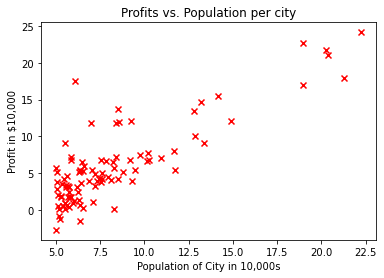

In [6]:
# Create a scatter plot of the data. To change the markers to red "x",
# we used the 'marker' and 'c' parameters
plt.scatter(x_train, y_train, marker='x', c='r') 

# Set the title
plt.title("Profits vs. Population per city")
# Set the y-axis label
plt.ylabel('Profit in $10,000')
# Set the x-axis label
plt.xlabel('Population of City in 10,000s')
plt.show()

The goal is to build a linear regression model to fit this data.
- With this model, we can then input a new city's population, and have the model estimate our restaurant's potential monthly profits for that city.

<a name="4"></a>
## 4. Refresher on linear regression

We will fit the linear regression parameters $(w,b)$ to the dataset(1-D case).
- The model function for linear regression, which is a function that maps from `x` (city population) to `y` (our restaurant's monthly profit for that city) is represented as 
    $$f(x) = wx + b$$
    

- To train a linear regression model, we want to find the best $(w,b)$ parameters that fit the dataset.  

    - To compare how one choice of $(w,b)$ is better or worse than another choice, we can evaluate it with a cost function $J(w,b)$
      - $J$ is a function of $(w,b)$. That is, the value of the cost $J(w,b)$ depends on the value of $(w,b)$.
  
    - The choice of $(w,b)$ that fits the data the best is the one that has the smallest cost $J(w,b)$.


- To find the values $(w,b)$ that gets the smallest possible cost $J(w,b)$, we can use a method called **gradient descent**. 
  - With each step of gradient descent, the parameters $(w,b)$ come closer to the optimal values that will achieve the lowest cost $J(w,b)$.
  

- The trained linear regression model can then take the input feature $x$ (city population) and output a prediction $f(x)$ (predicted monthly profit for a restaurant in that city).

<a name="5"></a>
## 5. Compute cost

Gradient descent involves repeated steps to adjust the value of the parameter $(w,b)$ to gradually get a smaller and smaller cost $J(w,b)$.
- At each step of gradient descent, it will be helpful to monitor the progress by computing the cost $J(w,b)$ as $(w,b)$ gets updated. 
- In this section, we will implement a function to calculate $J(w,b)$ so that we can check the progress of the gradient descent implementation.

#### Cost function
As you may recall from the lecture, for one variable, the cost function for linear regression $J(w,b)$ can defined as the Mean Squared Error (MSE) of the training data set $ \mathcal{D}=\left\{\left(x^{(i)}, y^{(i)}\right), i=1, \cdots, M\right\} $:


$$J(w,b) = \operatorname{MSE}(f, \mathcal{D})= \frac{1}{M} \sum\limits_{i = 1}^{M} (y^{(i)} - f(x^{(i)}))^2 $$

- $f(x^{(i)})$ is the model's prediction of our restaurant's profit, as opposed to $y^{(i)}$, which is the actual profit that is recorded in the data.
- $M$ is the number of training examples in the dataset.

#### Model prediction

- For linear regression with one variable, the prediction of the model $f$ for an example $x^{(i)}$ is represented as:

$$ f(x^{(i)}) = wx^{(i)} + b$$

This is the equation for a line, with an intercept $b$ and a slope $w$.

#### Implementation

Let's see the `compute_cost()` function below for computing the cost $J(w,b)$.

### 5.1 Implement cost function

The `compute_cost` below is to:

* Iterate over the training examples, and for each example, compute:
    * The prediction of the model for that example 
    $$
    f(x^{(i)}) =  wx^{(i)} + b 
    $$
   
    * The cost for that example  $$ \mathrm{cost}^{(i)} =  (y^{(i)} - f(x^{(i)}))^2$$
    

* Return the total cost over all examples
$$J(w,b) = \frac{1}{M} \sum\limits_{i = 1}^{M} \mathrm{cost}^{(i)}$$
  * Here, $M$ is the number of training examples and $\sum$ is the summation operator.

In [7]:
# FUNCTION: compute_cost

def compute_cost(x, y, w, b): 
    """
    Computes the cost function for linear regression.
    
    Args:
        x (ndarray): Shape (m,) Input to the model (Population of cities) 
        y (ndarray): Shape (m,) Label (Actual profits for the cities)
        w, b (scalar): Parameters of the model
    
    Returns
        total_cost (float): The cost of using w,b as the parameters for linear regression
               to fit the data points in x and y
    """
    # number of training examples
    m = x.shape[0] 
    
    total_cost = 0

    cost=0
    for i in range(m):
        f_wb = w*x[i]+b
        cost += (y[i] - f_wb)**2
    
    total_cost = cost/(m) 

    return total_cost

We can try if our implementation by running the following code:

In [8]:
# Compute cost with some initial values for paramaters w, b
initial_w = 2
initial_b = 1

cost = compute_cost(x_train, y_train, initial_w, initial_b)
print(type(cost))
print(f'Cost at initial w (zeros): {cost:.3f}')

<class 'numpy.float64'>
Cost at initial w (zeros): 150.407


<a name="6"></a>
## 6. Gradient descent 

In this section, we will implement the gradient for parameters $w, b$ for linear regression. 

As described in the lecture slides, the gradient descent algorithm is:

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & \phantom {0000} b := b -  \alpha \frac{\partial J(w,b)}{\partial b} \newline       \; & \phantom {0000} w := w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{1}  \; & 
\newline & \rbrace\end{align*}$$

where the parameters $w, b$ are both updated simultaniously and where  
$$
\frac{\partial J(w,b)}{\partial b}  = \frac{2}{M} \sum\limits_{i = 1}^{M} (f(x^{(i)}) - y^{(i)}) \tag{2}
$$
$$
\frac{\partial J(w,b)}{\partial w}  = \frac{2}{M} \sum\limits_{i = 1}^{M} (f(x^{(i)}) -y^{(i)})x^{(i)} \tag{3}
$$
* $M$ is the number of training examples in the dataset.

    
* $f(x^{(i)})$ is the model's prediction, while $y^{(i)}$, is the target value.


We will implement a function called `compute_gradient` which calculates $\frac{\partial J(w)}{\partial w}$, $\frac{\partial J(w)}{\partial b}$ .

<a name="ex02"></a>
### 6.1 Compute gradient

Let's complete the `compute_gradient` function to:

* Iterate over the training examples, and for each example, compute:
    * The prediction of the model for that example 
    $$
    f(x^{(i)}) =  wx^{(i)} + b 
    $$
   
    * The gradient for the parameters $w, b$ from that example 
        $$
        \frac{\partial J^{(i)}(w,b)}{\partial b}  =  (f(x^{(i)}) - y^{(i)}) 
        $$
        $$
        \frac{\partial J^{(i)}(w,b)}{\partial w}  =  (f(x^{(i)}) -y^{(i)})x^{(i)} 
        $$
    

* Return the total gradient update from all the examples
    $$
    \frac{\partial J(w,b)}{\partial b}  = \frac{2}{M} \sum\limits_{i = 1}^{M} \frac{\partial J^{(i)}(w,b)}{\partial b}
    $$
    
    $$
    \frac{\partial J(w,b)}{\partial w}  = \frac{2}{M} \sum\limits_{i = 1}^{M} \frac{\partial J^{(i)} (w,b)}{\partial w}
    $$
  * Here, $M$ is the number of training examples and $\sum$ is the summation operator.

In [9]:
# FUNCTION: compute_gradient
def compute_gradient(x, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      x (ndarray): Shape (m,) Input to the model (Population of cities) 
      y (ndarray): Shape (m,) Label (Actual profits for the cities)
      w, b (scalar): Parameters of the model  
    Returns
      dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
      dj_db (scalar): The gradient of the cost w.r.t. the parameter b     
     """
    
    # Number of training examples
    m = x.shape[0]
    
    dj_dw = 0
    dj_db = 0
    
    for i in range(m):
        f_wb = w*x[i]+b
        dj_db += f_wb - y[i]
        dj_dw += (f_wb - y[i])*x[i]
    dj_dw  = dj_dw * 2 / m
    dj_db  = dj_db * 2 / m
        
    return dj_dw, dj_db

Run the cells below to check the implementation of the `compute_gradient` function with two different initializations of the parameters $w$,$b$.

In [10]:
# Compute and display gradient with w initialized to zeroes
initial_w = 0
initial_b = 0

tmp_dj_dw, tmp_dj_db = compute_gradient(x_train, y_train, initial_w, initial_b)
print('Gradient at initial w, b (zeros):', tmp_dj_dw, tmp_dj_db)

Gradient at initial w, b (zeros): -130.65769949111345 -11.67827010309278


In [11]:
# Compute and display cost and gradient with non-zero w
test_w = 0.2
test_b = 0.2
tmp_dj_dw, tmp_dj_db = compute_gradient(x_train, y_train, test_w, test_b)

print('Gradient at test w, b:', tmp_dj_dw, tmp_dj_db)

Gradient at test w, b: -94.8322023622887 -8.014350103092783


<a name="2.6"></a>
### 6.2 Learning parameters using gradient descent 

We will now find the optimal parameters of a linear regression model by using (batch) gradient descent. Here batch refers to running all the examples in one iteration.

- A good way to verify that gradient descent is working correctly is to look
at the value of $J(w,b)$ and check that it is decreasing with each step. 

- Assuming we have implemented the gradient and computed the cost correctly and we have an appropriate value for the learning rate alpha, $J(w,b)$ should never increase and should converge to a steady value by the end of the algorithm.

In [12]:
def gradient_descent(x, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      x :    (ndarray): Shape (m,)
      y :    (ndarray): Shape (m,)
      w_in, b_in : (scalar) Initial values of parameters of the model
      cost_function: function to compute cost
      gradient_function: function to compute the gradient
      alpha : (float) Learning rate
      num_iters : (int) number of iterations to run gradient descent
    Returns
      w : (ndarray): Shape (1,) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(x)
    
    # An array to store cost J and w's at each iteration — primarily for graphing later
    J_history = []
    w_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_dw, dj_db = gradient_function(x, y, w, b)  

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(x, y, w, b)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0:
            w_history.append(w)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w, b, J_history, w_history #return w and J,w history for graphing

Now let's run the gradient descent algorithm above to learn the parameters for our dataset.

In [13]:
# initialize fitting parameters. Recall that the shape of w is (n,)
initial_w = 0.
initial_b = 0.

# some gradient descent settings
iterations = 1500
alpha = 0.01

start_time = timeit.default_timer()
w,b,_,_ = gradient_descent(x_train ,y_train, initial_w, initial_b, 
                           compute_cost, compute_gradient, alpha, iterations)
elapsed = timeit.default_timer() - start_time
print("Time elapsed: %.5f s."% elapsed)
print("w,b found by gradient descent:", w, b)

Iteration    0: Cost    33.54   
Iteration  150: Cost     9.92   
Iteration  300: Cost     9.28   
Iteration  450: Cost     9.06   
Iteration  600: Cost     8.99   
Iteration  750: Cost     8.97   
Iteration  900: Cost     8.96   
Iteration 1050: Cost     8.96   
Iteration 1200: Cost     8.95   
Iteration 1350: Cost     8.95   
Time elapsed: 0.20270 s.
w,b found by gradient descent: 1.1912611946381648 -3.8781376908655907


We will now use the final parameters from gradient descent to plot the linear fit. 

Recall that we can get the prediction for a single example $f(x^{(i)})= wx^{(i)}+b$. 

To calculate the predictions on the entire dataset, we can loop through all the training examples and calculate the prediction for each example. This is shown in the code block below.

In [14]:
m = x_train.shape[0]
predicted = np.zeros(m)

for i in range(m):
    predicted[i] = w * x_train[i] + b

We will now plot the predicted values to see the linear fit.

Text(0.5, 0, 'Population of City in 10,000s')

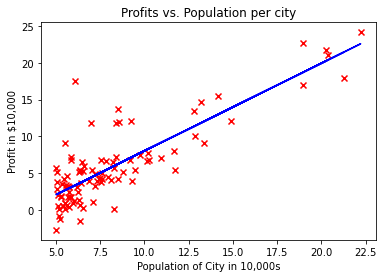

In [15]:
# Plot the linear fit
plt.plot(x_train, predicted, c = "b")

# Create a scatter plot of the data. 
plt.scatter(x_train, y_train, marker='x', c='r') 

# Set the title
plt.title("Profits vs. Population per city")
# Set the y-axis label
plt.ylabel('Profit in $10,000')
# Set the x-axis label
plt.xlabel('Population of City in 10,000s')

The final values of $w,b$ can also be used to make predictions on profits. Let's predict what the profit would be in areas of 35,000 and 70,000 people. 

- The model takes in population of a city in 10,000s as input. 

- Therefore, 35,000 people can be translated into an input to the model as `np.array([3.5])`

- Similarly, 70,000 people can be translated into an input to the model as `np.array([7.])`


In [16]:
predict1 = 3.5 * w + b
print('For population = 35,000, we predict a profit of $%.2f .' % (predict1*10000))

predict2 = 7.0 * w + b
print('For population = 70,000, we predict a profit of $%.2f .' % (predict2*10000))

For population = 35,000, we predict a profit of $2912.76 .
For population = 70,000, we predict a profit of $44606.91 .


<a name="2.6"></a>
### 6.3 Compare with scikit-learn

Try to use ``LinearRegression`` from scikit-learn. The solutions are slightly different.

In [17]:
start_time = timeit.default_timer()
reg = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
elapsed = timeit.default_timer() - start_time
print("Time elapsed: %.5f s."% elapsed)
print("w,b found by sklearn regression:", reg.coef_[0], reg.intercept_)

Time elapsed: 0.01151 s.
w,b found by sklearn regression: 1.1930336441895937 -3.895780878311852


In [18]:
m = x_train.shape[0]
predicted = np.zeros(m)

for i in range(m):
    predicted[i] = reg.predict(x_train[i].reshape(-1, 1))

Text(0.5, 0, 'Population of City in 10,000s')

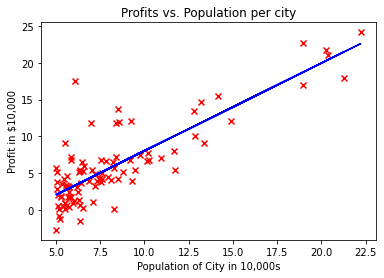

In [19]:
# Plot the linear fit
plt.plot(x_train, predicted, c = "b")

# Create a scatter plot of the data. 
plt.scatter(x_train, y_train, marker='x', c='r') 

# Set the title
plt.title("Profits vs. Population per city")
# Set the y-axis label
plt.ylabel('Profit in $10,000')
# Set the x-axis label
plt.xlabel('Population of City in 10,000s')

In [20]:
predict1 = reg.predict(np.array([[3.5]]))
print('For population = 35,000, LinearRegression from sklearn predicts a profit of $%.2f .' % (predict1*10000))

predict2 = reg.predict(np.array([[7.0]]))
print('For population = 70,000, LinearRegression from sklearn predicts a profit of $%.2f .' % (predict2*10000))

For population = 35,000, LinearRegression from sklearn predicts a profit of $2798.37 .
For population = 70,000, LinearRegression from sklearn predicts a profit of $44554.55 .
